In [18]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_fscore_support
import cv2
import pandas as pd
# np.set_printoptions(threshold=np.inf)

In [19]:
sz=128
dataX=np.zeros((3750,sz,sz))
path='dataset/'
for i in range(3749):
    img = cv2.imread(path+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (sz,sz), interpolation = cv2.INTER_AREA)
    img=img.reshape(1, sz, sz)
    img=img_to_array(img[:,:]) 
    dataX[i,:,:] =img_to_array(img[:,:]) 
dataY = pd.read_csv('dataset.csv')
dataY = pd.DataFrame.to_numpy(dataY)
dataY =dataY.reshape(len(dataY),)
dataY = to_categorical(dataY)

In [20]:
def data_split(dataX, dataY):
    X_train, X_test, y_train, y_test = train_test_split(
    dataX, dataY, test_size=0.2, random_state=2)
    return X_train, X_test, y_train, y_test

In [4]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
trainX, testX, trainY, testY=data_split(dataX, dataY)
trainX, testX = prep_pixels(trainX, testX)
trainX = trainX.reshape((trainX.shape[0], sz, sz, 1))
testX = testX.reshape((testX.shape[0], sz, sz, 1))

In [6]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(3000, 128, 128, 1), y=(3000, 5)
Test: X=(750, 128, 128, 1), y=(750, 5)


In [7]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=2):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        print(trainX.shape)
        history = model.fit(trainX, trainY, epochs=3, batch_size=64, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories, model

In [8]:
def summarize_diagnostics(histories):
    fig, (ax1, ax2) = pyplot.subplots(2, 1)
    for i in range(len(histories)):
        # plot loss
        ax1.title.set_text('Cross Entropy Loss')
        ax1.plot(histories[i].history['loss'], color='blue', label='train')
        ax1.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
#         pyplot.subplot(2, 1, 2)
        ax2.title.set_text('Classification Accuracy')
        ax2.plot(histories[i].history['accuracy'], color='blue', label='train')
        ax2.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [9]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

In [12]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='PReLU', kernel_initializer='he_uniform', input_shape=(sz, sz, 1)))
    model.add(Conv2D(32, (3, 3), activation='PReLU', kernel_initializer='he_uniform', input_shape=(sz, sz, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='PReLU', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='PReLU', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='PReLU', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='PReLU', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='PReLU', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(100, activation='PReLU', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9, decay = 1e-04)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

(1500, 128, 128, 1)
> 20.400
(1500, 128, 128, 1)
> 19.733


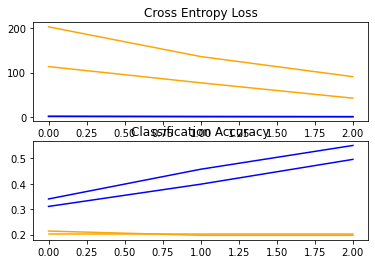

Accuracy: mean=20.067 std=0.333, n=2


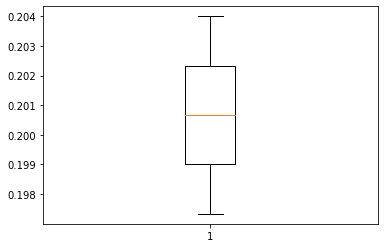

In [13]:
# evaluate model
scores, histories, model = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# model.save('final_model.h5')

In [26]:
y_tar=np.argmax(testY,1)
print(y_tar)

[2 1 2 1 3 0 3 3 4 1 2 2 3 1 0 0 0 2 2 4 1 0 0 2 4 3 2 4 0 3 2 1 0 2 0 1 2
 1 0 1 4 4 0 2 4 0 0 3 0 1 1 4 4 4 2 4 0 1 3 3 4 0 0 4 2 4 4 4 2 3 3 3 0 3
 0 3 4 3 3 1 2 2 0 4 3 2 2 0 4 3 2 1 2 3 2 4 3 0 2 3 0 1 4 4 0 2 4 1 4 4 0
 3 2 2 2 4 1 2 1 4 3 0 3 0 1 1 0 3 3 1 2 3 2 0 2 4 0 3 0 2 0 4 0 1 4 0 2 4
 0 0 3 4 2 2 1 1 2 1 4 1 1 2 3 1 1 4 2 0 1 1 1 2 4 3 4 3 2 3 1 3 3 4 2 3 2
 1 3 1 1 2 3 4 3 4 4 1 2 1 3 1 2 0 0 4 1 4 1 3 2 4 0 3 1 3 4 4 0 4 2 0 3 4
 2 1 4 3 1 4 0 3 0 4 1 1 3 0 2 3 0 0 2 1 4 4 2 2 1 0 1 4 0 0 1 4 1 2 4 3 0
 4 2 2 0 2 4 0 1 0 3 1 1 4 0 3 4 0 2 0 4 3 0 0 3 2 2 2 2 2 2 1 3 3 0 4 4 2
 4 1 1 2 0 0 0 2 3 2 0 3 3 3 4 4 0 4 2 1 1 4 0 4 4 0 2 2 1 0 4 0 2 0 2 0 1
 0 2 1 3 1 3 2 1 1 4 0 3 3 1 0 2 1 3 2 2 2 4 3 4 2 0 0 2 4 1 1 3 2 2 1 1 3
 4 2 4 1 0 4 2 3 1 4 2 2 4 1 4 3 2 1 0 1 3 0 4 0 3 1 1 1 3 1 2 1 3 0 4 0 3
 0 1 2 1 1 1 3 2 4 2 0 1 3 1 1 3 4 0 0 1 0 0 2 4 1 1 1 4 2 4 3 3 2 4 2 2 1
 1 1 3 1 3 2 3 1 1 0 1 0 3 3 2 3 1 4 1 1 3 1 2 0 1 4 3 2 4 1 4 0 3 3 4 3 4
 0 1 3 3 4 3 2 0 4 3 0 2 

In [29]:
pY_test=model.predict(testX)
groundTruth=y_tar
predections= pY_test.argmax(axis=1)
cm=confusion_matrix(groundTruth,predections)
print(cm)

[[  0   0   0   0 152]
 [  0   0   0   0 152]
 [  0   0   0   0 151]
 [  0   0   0   0 147]
 [  0   0   0   0 148]]


[[  0   0   0   0 152]
 [  0   0   0   0 152]
 [  0   0   0   0 151]
 [  0   0   0   0 147]
 [  0   0   0   0 148]]
